# Breast Cancer project goals to achieve:

- Apply unsupervised method on the breast cancer dataset
- Apply various unsupervised techniques and see which work best for the data
- Apply pca, kmeans as a preprocessing
- Take the test data and create a label for the test data using the semi-supervised method
- Have a validation dataset to verify the create label is close to the validation test label before propagating it into the test set

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces,make_blobs,load_breast_cancer
from skimage.io import imshow
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,preprocessing
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans
from sklearn.metrics import silhouette_samples,silhouette_score,classification_report,homogeneity_completeness_v_measure,accuracy_score
from sklearn.pipeline import Pipeline
from clusterval import Clusterval
import warnings
warnings.filterwarnings("ignore")

# Dataset Loading

The Breast Cancer data set is a real-valued multivariate data that consists of two classes, where each class signifies whether a patient has breast cancer or not. The two categories are: malignant and benign.

The malignant class has 212 samples, whereas the benign class has 357 samples.

It has 30 features shared across all classes: radius, texture, perimeter, area, smoothness, fractal dimension, etc.

In [2]:
breast_cancer = load_breast_cancer()

In [3]:
breast_cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

# About Dataset

In [4]:
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
breast_cancer['data'].shape, breast_cancer['target'].shape

((569, 30), (569,))

In [6]:
print("unique target number: ",np.unique(breast_cancer['target']))

unique target number:  [0 1]


In [7]:
X=breast_cancer.data
labels=breast_cancer.target

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
X.shape, labels.shape

((569, 30), (569,))

In [10]:
X_scaled.shape

(569, 30)

# Train-Test Split

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled, labels, test_size=0.2, stratify=labels, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: (455, 30)
y_train shape: (455,)


# Dimensionality Reduction

We will use ``Principal component analysis (PCA)``to eliminate features. 

It is a technique used to ``emphasize variation`` and ``bring out strong patterns`` in a dataset.

## Principal component analysis (PCA)

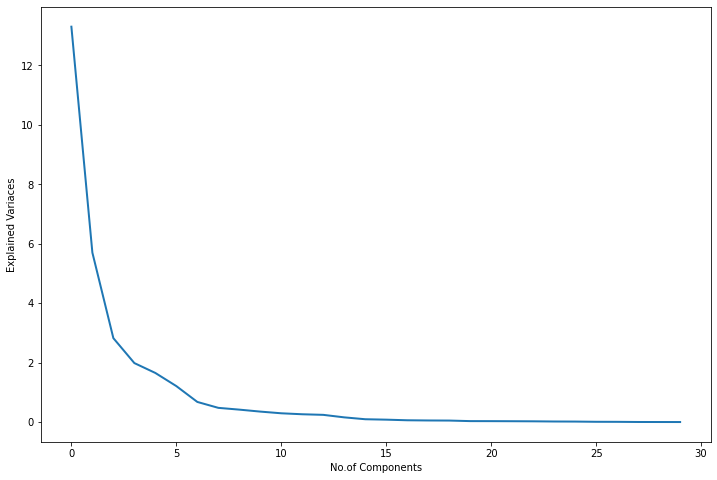

In [12]:
pca=PCA()
pca.fit(X_scaled)
plt.figure(1, figsize=(12,8))
plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('No.of Components')
plt.ylabel('Explained Variaces')
plt.show()

**We can see above the values after around 2 are the same. This means that there are 2 important components that can describe the data well.**

In [13]:
#n_components=2
pca=PCA(n_components=0.95, whiten=True)
pca.fit(X_scaled)

PCA(n_components=0.95, whiten=True)

**Transform the training and testing sets using PCA**

In [14]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
print(f"Shape before {X_train.shape} vs shape after {X_train_pca.shape}")

Shape before (455, 30) vs shape after (455, 10)


**So now we were able to decrease the dimension of the inputs.**

**LogisticRegression to study the accuracy of the model after we applied the PCA transformation.**

In [15]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(f"Accuracy score:{(metrics.accuracy_score(y_test, y_pred))}")

Accuracy score:0.9649122807017544


# KMeans - silhouette score

In [16]:
kmeans_per_k=[KMeans(n_clusters=k,random_state=42).fit(X_scaled) for k in range(2,15)]
inertia=[model.inertia_ for model in kmeans_per_k]

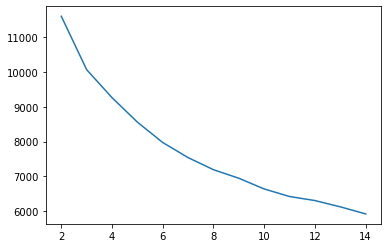

In [17]:
plt.plot(range(2,15),inertia)

In [18]:
sil_score=[silhouette_score(X_scaled,model.labels_) for model in  kmeans_per_k[:]]

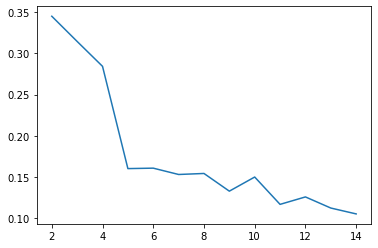

In [19]:
plt.plot(range(2,15),sil_score)

## Using Clusterval to determine the optimal number of clusters

In [20]:
c = Clusterval(min_k=1, max_k=6, algorithm='kmeans',bootstrap_samples=200, index='CVNN')
c.evaluate(X)

Clusterval( min_k=1, max_k=6, algorithm=kmeans, bootstrap_samples=200, index=['CVNN'])
final_k = 2

In [21]:
print(c.long_info)

* Minimum number of clusters to test: 1
* Maximum number of clusters to test: 6
* Number of bootstrap samples generated: 200
* Clustering algorithm used: kmeans

* Validation Indices calculated: ['CVNN']

* Among all indices: 



* According to the majority rule, the best number of clusters is 2


* 1 proposed 2 as the best number of clusters 

			***** Conclusion *****			
       CVNN
1  1.000000
2  0.473738
3  0.764280
4  0.674387
5  1.248981
6  0.722807

* The best partition is:
[1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1

**According to the Clusterval majority rule using kmeans algorithm, the best number of clusters is 2**

In [22]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(X_scaled)
y_pred=Kmean.predict(X_scaled)

In [23]:
# kmean will give you the label according to the index ( has to do with the cluster)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [24]:
# we can use attribute like labels_ to get the index given by the model
Kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [25]:
np.allclose(y_pred,Kmean.labels_)

True

**Both y_pred and labels are same**

# Clustering for the Preprocessing

## logreg

In [26]:
log_reg=LogisticRegression(multi_class="ovr",random_state=42,max_iter=2000,C=0.1)
log_reg.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr', random_state=42)

In [27]:
print(f"training score {log_reg.score(X_train,y_train)}")
print(f"test score {log_reg.score(X_test,y_test)}")

training score 0.9846153846153847
test score 0.9649122807017544


## apply clustering for the preprocessing

In [28]:
score=[]
for i in range(2,15):
    model=KMeans(n_clusters=i)
    model.fit(X_train)
    score.append(model.inertia_)

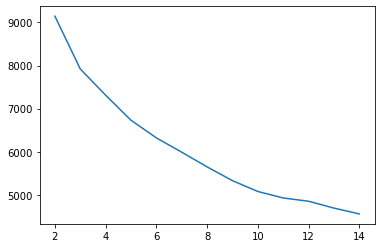

In [29]:
plt.plot(range(2,15),score)

In [30]:
sil_score=[]
for i in range(2,15):
    model=KMeans(n_clusters=i)
    model.fit(X_train)
    sil_score.append(silhouette_score(X_train,model.labels_))

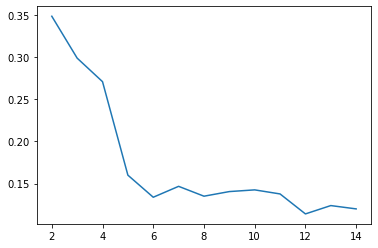

In [31]:
plt.plot(range(2,15),sil_score)

## with k=2

In [32]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=2,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=2, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [33]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.9428571428571428
0.9298245614035088


## with k=3

In [34]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=3,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=3, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [35]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.9538461538461539
0.9298245614035088


## with k=10

In [36]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=10,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=10, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [37]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.9714285714285714
0.9473684210526315


## GridSearchCV

In [38]:
from sklearn.model_selection import GridSearchCV
param={"Kmean__n_clusters":range(2,15)}
      #"logreg__C":[0.001,0.01,10]}
grid=GridSearchCV(pipe,param_grid=param,cv=3,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Kmean',
                                        KMeans(n_clusters=10, random_state=42)),
                                       ('logreg',
                                        LogisticRegression(max_iter=2000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'Kmean__n_clusters': range(2, 15)})

In [39]:
grid.best_estimator_

Pipeline(steps=[('Kmean', KMeans(n_clusters=9, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [40]:
grid.best_score_

0.9692256303009179

In [41]:
grid.score(X_train,y_train)

0.9714285714285714

In [42]:
grid.score(X_test,y_test)

0.9473684210526315

In [43]:
grid.best_params_

{'Kmean__n_clusters': 9}

**According to GridSearchCV, 9 is the best number of clusters**

## apply PCA+KMeans+logreg

In [44]:
pipe=Pipeline([
    ("pca",PCA(n_components=0.95)),
    ("Kmean",KMeans(n_clusters=9,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr",C=0.1))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('Kmean', KMeans(n_clusters=9, random_state=42)),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [45]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.9692307692307692
0.9473684210526315


# Semi-supervised Learning

**lets consider only we have 50 of the training label for supervised task**

In [46]:
labeled_data=50

In [47]:
np.unique(y_train[:labeled_data],return_counts=True)

(array([0, 1]), array([18, 32]))

In [48]:
log_reg=LogisticRegression(random_state=42,multi_class="ovr",max_iter=2000,C=0.1)
log_reg.fit(X_train[:labeled_data],y_train[:labeled_data])

LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr', random_state=42)

In [49]:
print(log_reg.score(X_train,y_train))
print(log_reg.score(X_test,y_test))

0.9626373626373627
0.9385964912280702


In [50]:
print(classification_report(y_test,log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        42
           1       0.93      0.97      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



## Steps to follow

First we need to cluster the training set.

Then we find the instances closest to the centroid

In [51]:
K=9
kmeans=KMeans(n_clusters=K,random_state=42)
X_transformed=kmeans.fit_transform(X_train)
print(X_transformed.shape)

(455, 9)


In [52]:
len(np.argmin(X_transformed,axis=0))

9

### getting the representative idx and data

In [53]:
representative_idx=np.argmin(X_transformed,axis=0)
X_instances=X_train[representative_idx]

In [54]:
# y_instances from the representatinve index
y_instances=y_train[representative_idx]
y_instances.reshape(9,-1)

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]])

In [55]:
log_reg=LogisticRegression(random_state=42,multi_class="ovr",max_iter=2000)
log_reg.fit(X_instances,y_instances)

LogisticRegression(max_iter=2000, multi_class='ovr', random_state=42)

In [56]:
print(log_reg.score(X_test,y_test))
print(log_reg.score(X_instances,y_instances))
print(log_reg.score(X_train,y_train))

0.9298245614035088
1.0
0.9164835164835164


In [57]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [58]:
labels[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1])

### give the label to all the instance that are in the same cluster

- label propagation

In [59]:
y_train_propagated_label=np.empty(len(X_train))
print(y_train_propagated_label.shape)
for i in range(K):
    y_train_propagated_label[kmeans.labels_==i]=y_instances[i]

(455,)


In [60]:
np.unique(y_train_propagated_label,return_counts=True)

(array([0., 1.]), array([137, 318]))

In [61]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([170, 285]))

In [62]:
y_train[300], y_train_propagated_label[300]

(0, 0.0)

### model training with the new propagated data

In [63]:
log_reg=LogisticRegression(multi_class="ovr",max_iter=2000,random_state=42)
log_reg.fit(X_train,y_train_propagated_label)
print(log_reg.score(X_test,y_test))

0.9210526315789473


### propagation accuracy

In [64]:
homogeneity_completeness_v_measure(y_train,y_train_propagated_label)

(0.5416434198888742, 0.5850825505575644, 0.56252562187013)

In [65]:
np.mean(y_train==y_train_propagated_label)

0.9054945054945055

In [66]:
accuracy_score(y_train,y_train_propagated_label)

0.9054945054945055

### Propagation accuracy is approximately 90%. We can try to improve it by propagating the labels only to a threshold near to the centroid.

 ## Increase the accuracy by propagating only to the instances that are really close to the centroid
 
 
if we propagate the instances to the full cluster it might have an outlier so the most commonly used technique is to propagate the label to some threshold closest to the centroid.
The commonly used threshold is a precentile according to the data.

In [67]:
print(f"cluster centroid shape : {kmeans.cluster_centers_.shape}")
print(f"cluster centroid label : {kmeans.labels_[0]}")

cluster centroid shape : (9, 30)
cluster centroid label : 3


In [68]:
X_transformed[0]

array([ 3.70054735,  5.47680319,  6.08201022,  2.49258826, 10.91467135,
        3.76135042,  9.51094235,  5.32281886, 20.62747343])

In [69]:
X_transformed[0][np.argmin(X_transformed[0])]

2.4925882578566014

In [70]:
percentile=80 # took 80% of the instances that are closest to the centroid
X_cluster_distance=X_transformed[np.arange(len(X_train)),kmeans.labels_]
for i in range(K):
    intra_cluster=kmeans.labels_==i
    cluster_dist=X_cluster_distance[intra_cluster]
    dist=np.percentile(cluster_dist,percentile)
    upper_dis=(X_cluster_distance>dist)
    X_cluster_distance[intra_cluster&upper_dis]=-1

In [71]:
X_cluster_distance[:20]

array([ 2.49258826,  3.59803653,  3.28951877,  3.73292161,  1.49696451,
        4.04535731, -1.        ,  2.77179738,  2.50682756,  2.06317099,
        2.78724245,  4.08598166,  1.86886777,  1.85765875,  2.57689926,
        1.57530743, -1.        ,  3.93262202, -1.        ,  1.19240448])

In [72]:
X_cluster_distance.shape

(455,)

In [73]:
np.sum(X_cluster_distance!=-1)

360

In [74]:
propagation_cutoff=(X_cluster_distance!=-1)
X_train_partially_select=X_train[propagation_cutoff]
y_train_partially_select=y_train_propagated_label[propagation_cutoff]

In [75]:
log_reg=LogisticRegression(multi_class="ovr",max_iter=2000,random_state=42)
log_reg.fit(X_train_partially_select,y_train_partially_select)
print(log_reg.score(X_test,y_test))

0.9210526315789473


In [76]:
np.mean(y_train_partially_select==y_train[propagation_cutoff])

0.925

### Accuracy increased from 90% to 92% by propagating only to the instances that are really close to the centroid